In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import least_squares
from scipy.fftpack import fft, fftfreq

#### Simulation of SIR model for various beta values (no demography)
Create an overseeable range of $\beta$ and $\gamma$ values to explore the SIR model's behavior in various settings. Starting with a non-demographic model, later cells will incorporate birth and death rates.

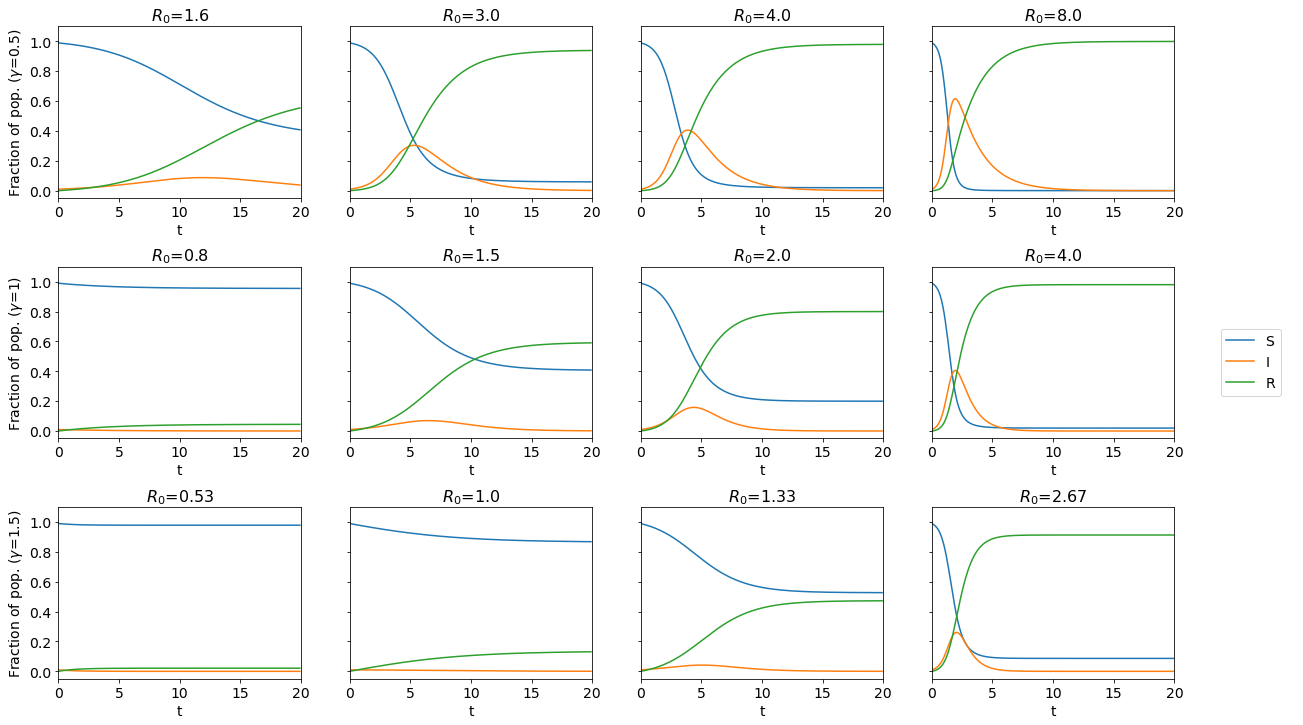

In [12]:
S0 = 0.99
I0 = 0.01
R0 = 0
SIR0 = [S0, I0, R0]
beta = [0.8, 1.5, 2, 4]
gamma = [0.5, 1, 1.5]
t = np.arange(0, 20, 0.1)
mu = 0
rho = 0

#ODE's from assignment
def ODE(init, t, beta, gamma, mu, rho):
    S, I, R = init
    dsdt = mu - beta * I * S - mu * S
    didt = beta * S * I - gamma * I - mu * I 
    drdt = (1 - rho) * gamma * I - mu * R
    return [dsdt, didt, drdt]

def ODEint(time, SIR0, beta, gamma, mu, rho):
    SIR = integrate.odeint(ODE, SIR0, time, args = (beta, gamma, mu, rho))
    return SIR

#Plot integrated ODE's for various beta
fig, im = plt.subplots(len(gamma), len(beta), sharey=True,figsize=(20,12))
for i in range(len(beta)):
    for j in range(len(gamma)):
        SIR = ODEint(t, SIR0, beta[i], gamma[j], mu, rho)
        im[j,i].plot(t, SIR)
        im[j,i].set_xlabel('t', fontsize=14)
        im[j,i].set_title('$R_0$='+str(round(beta[i]/gamma[j],2)),fontsize=16)
        im[j,i].set_yticklabels(np.round(np.arange(-0.2,1.2,0.2),1),fontsize=14)
        im[j,i].set_xticks(np.round(np.arange(0,30,5),0))
        im[j,i].set_xticklabels(np.round(np.arange(0,30,5),0),fontsize=14)
        im[j,i].set_xlim((0,20))
        im[j,i].set_ylim((-0.05,1.1))
plt.subplots_adjust(hspace=0.4)
fig.legend(labels=['S','I','R'], loc="right",borderaxespad=1.6,fontsize=14)
im[0,0].set_ylabel('Fraction of pop. ($\gamma$=0.5)', fontsize=14)
im[1,0].set_ylabel('Fraction of pop. ($\gamma$=1)', fontsize=14)
im[2,0].set_ylabel('Fraction of pop. ($\gamma$=1.5)', fontsize=14)
fig.savefig('SIRdynamics.pdf',dpi=100)

#### Create phase-space diagrams by solving system for varying $S_0$
Create phase-space plots for the same combinations of $\beta$ and $\gamma$

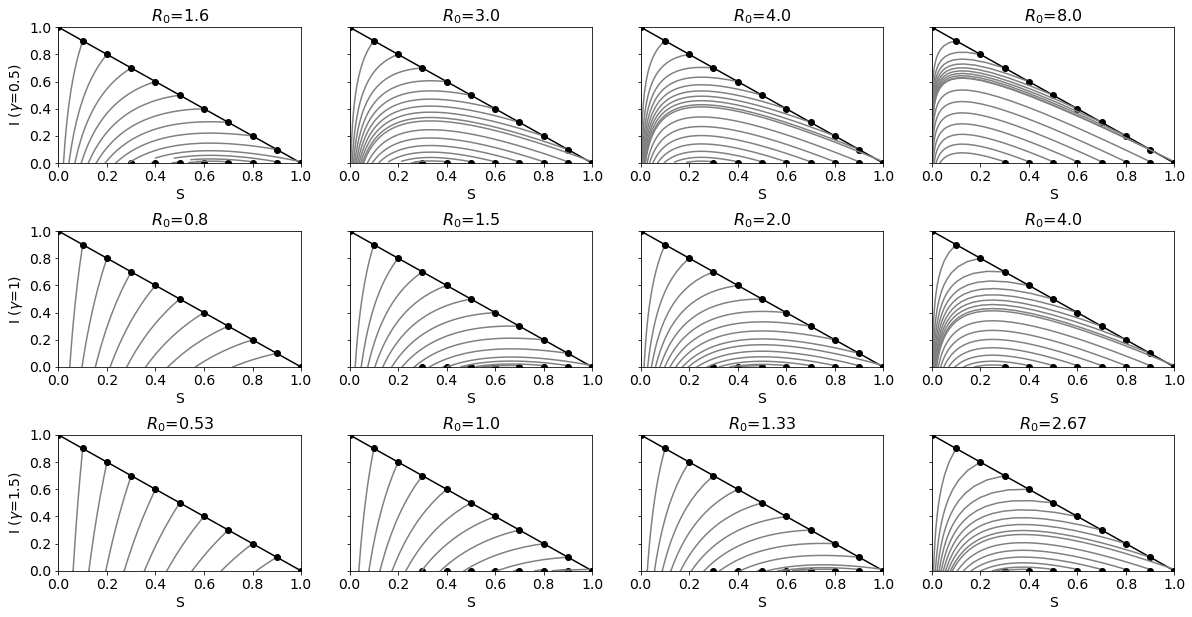

In [13]:
S0 = np.arange(0,1.1,0.1)
fig, im = plt.subplots(len(gamma), len(beta), sharey=True, figsize=(20,10))
for i in range(len(beta)):
    for j in range(len(gamma)):
        im[j,i].set_xlabel('S', fontsize=14)
        im[j,i].set_xlim([0,1])
        im[j,i].set_ylim([0,1])
        im[j,i].set_xticklabels(np.round(np.arange(0,1.2,0.2),1),fontsize=14)
        im[j,i].set_yticklabels(np.round(np.arange(0,1.2,0.2),1),fontsize=14)
        im[j,i].plot(S0, 1 - S0, "black")
        im[j,i].set_title('$R_0$='+str(round(beta[i]/gamma[j],2)),fontsize=16)

        for sus in S0:
            SIR = ODEint(t, [sus, (1 - sus) , 0], beta[i], gamma[j], mu, rho)
            im[j,i].plot(SIR[:,0],SIR[:,1],'grey')
            im[j,i].plot(sus, 1 - sus, 'ko')
            if beta[i]/gamma[j] >= 1 and sus > 0.3: 
                SIR = ODEint(t, [sus, I0, (1 - sus-I0)], beta[i], gamma[j], mu, rho)
                im[j,i].plot(SIR[:,0],SIR[:,1],'grey')
                im[j,i].plot(sus, 0, "ko")

plt.subplots_adjust(hspace=0.5)
im[0,0].set_ylabel('I ($\gamma$=0.5)', fontsize=14)
im[1,0].set_ylabel('I ($\gamma$=1)', fontsize=14)
im[2,0].set_ylabel('I ($\gamma$=1.5)', fontsize=14)
    
fig.savefig('SIRphaseplot.pdf',dpi=100)

#### Fit SIR model to boys school data by Least Squares
Addition of 1 infected individual at the start of the measurement as the outbreak is expected to originate from 1 individual. Estimate $\beta$ and $\gamma$ by least squares and plot observed data with fitted values.

Beta = 1.6651138728481902  and Gamma = 0.4476097382046872
So R0 = 3.7200126152902224


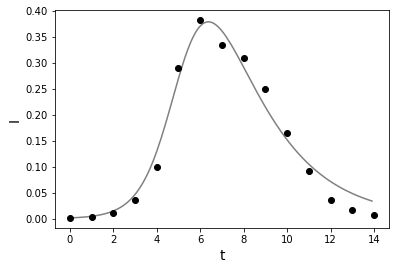

In [4]:
infected_data = np.array([1., 3., 8., 28., 75., 221., 291., 255., 235., 190., 125., 70., 28., 12., 5.])

popsize =  763
I0 = infected_data[0] / popsize
S0 = 1 - I0
SIR0 = [S0, I0, R0]
It = infected_data / popsize
t = range(15)

def res(params, t, SIR0, It, mu, rho): 
    It_hat = ODEint(t, SIR0, params[0], params[1], mu, rho)
    resids = It - It_hat[:,1]
    return resids

result = least_squares(res, [beta[2], gamma[1]] , args=(t, SIR0, It, mu, rho))
beta_hat = result.x[0]
gamma_hat = result.x[1]

x_range = np.arange(0, 14, 0.1)
SIR = ODEint(x_range, SIR0, beta_hat, gamma_hat, mu, rho)
plt.plot(x_range, SIR[:,1],'grey')
plt.plot(t, It, "ko")
plt.xlabel('t',fontsize=14)
plt.ylabel('I',fontsize=14)
print('Beta =',beta_hat,' and Gamma =',gamma_hat)
print('So R0 =', beta_hat/gamma_hat)
plt.savefig('boysschool.pdf',dpi=100)

#### Vaccination plan
The cell above shows an estimated $R_0$ of 3.704. This means that an individual would infect 3.704 other individuals in a completely susceptible population. We want to vaccinate a percentage of the population so 3.704 multiplied by the remaining susceptible population is < 1.

$3.704 \cdot S_0 < 1$ which results in $S_0 < 0.27$. This shows we have to vaccinate at least 73 percent ($1-0.27=0.73$) of the population to prevent an epidemic from happening. In the current population, this would be equal to $0.73*763=557$ vaccinated individuals.

#### Simulation of SIR model for various beta values with demography
Addition of a natural birth and death rate of 0.02, rates are equal to preserve population size. Some oscillations become visible.

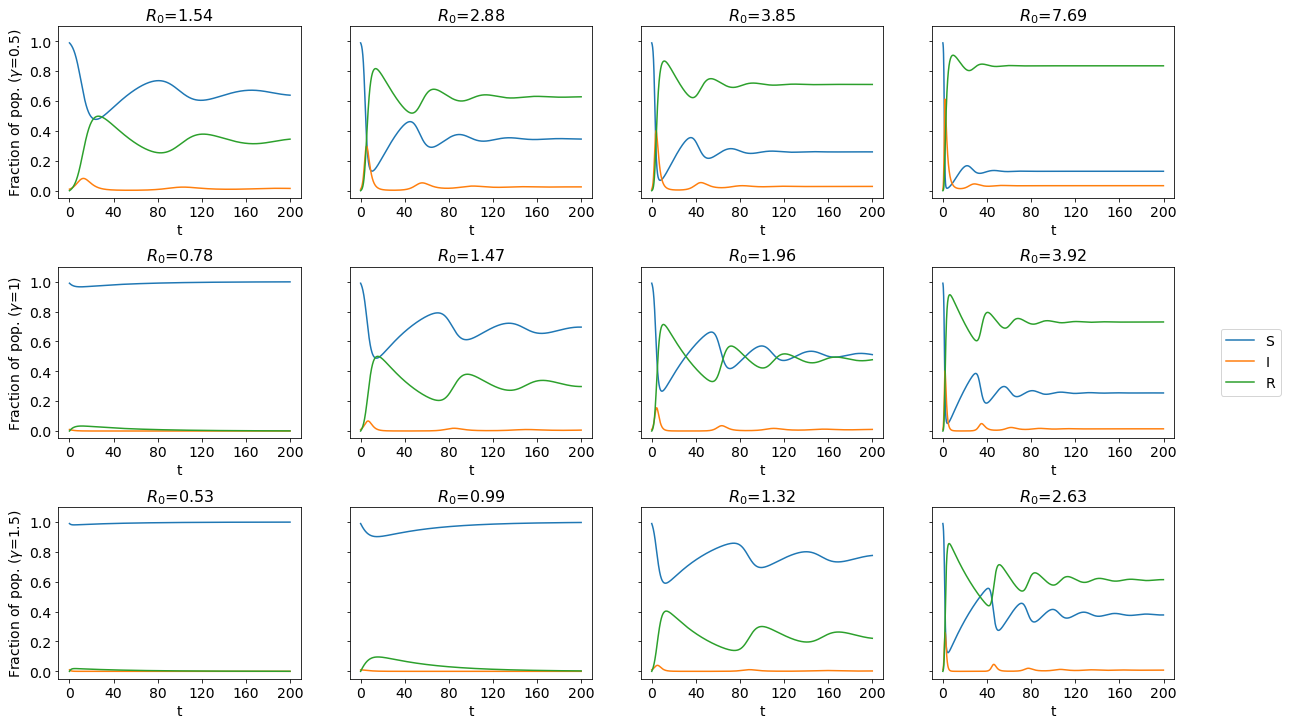

In [5]:
S0 = 0.99
I0 = 0.01
R0 = 0
SIR0 = [S0, I0, R0]
beta = [0.8, 1.5, 2, 4]
gamma = [0.5, 1, 1.5]
t = np.arange(0, 200, 0.1)
mu = 0.02 #Natural birth and death rate set to 1/50
rho = 0

#Plot integrated ODE's for various beta
fig, im = plt.subplots(len(gamma), len(beta), sharey=True,figsize=(20,12))
for i in range(len(beta)):
    for j in range(len(gamma)):
        SIR = ODEint(t, SIR0, beta[i], gamma[j], mu, rho)
        im[j,i].plot(t, SIR)
        im[j,i].set_xlabel('t', fontsize=14)
        im[j,i].set_title('$R_0$='+str(round(beta[i]/(gamma[j]+mu),2)),fontsize=16)
        im[j,i].set_yticklabels(np.round(np.arange(-0.2,1.2,0.2),1),fontsize=14)
        im[j,i].set_ylim((-0.05,1.1))
        im[j,i].set_xticks(np.round(np.arange(0,220,40),0))
        im[j,i].set_xticklabels(np.round(np.arange(0,220,40),0),fontsize=14)
plt.subplots_adjust(hspace=0.4)
fig.legend(labels=['S','I','R'], loc="right",borderaxespad=1.6,fontsize=14)
im[0,0].set_ylabel('Fraction of pop. ($\gamma$=0.5)', fontsize=14)
im[1,0].set_ylabel('Fraction of pop. ($\gamma$=1)', fontsize=14)
im[2,0].set_ylabel('Fraction of pop. ($\gamma$=1.5)', fontsize=14)
fig.savefig('SIRdynamicsdemo.pdf',dpi=100)

#### Fourier analysis
A smaller range of $\beta$ and $\gamma$ values is shown, as low R-values do not present oscillations and are uninformative. Some combinations with oscillations are shown below.

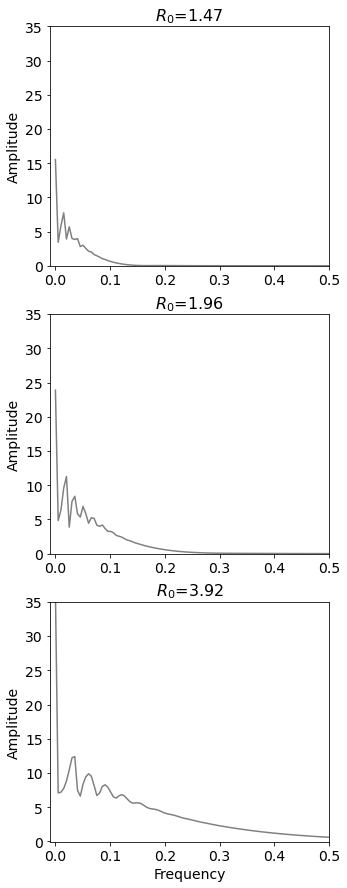

In [6]:
S0 = 0.99
I0 = 0.01
R0 = 0
SIR0 = [S0, I0, R0]
beta = [1.5, 2, 4]
gamma = [1]
t = np.arange(0, 200, 0.1)
mu = 0.02 #Natural birth and death rate set to 1/50
rho = 0

fig, im = plt.subplots(len(beta), len(gamma), sharex=False,figsize=(5,15))
for i in range(len(beta)):
    for j in range(len(gamma)):
        SIR = ODEint(t, SIR0, beta[i], gamma[j], mu, rho)
        FT = fft(SIR[:,1])
        FTfreq = fftfreq(len(SIR[:,1]))
        im[i].plot(np.linspace(0,0.5,100),np.abs(FT[0:100]),'grey')
        im[i].set_ylabel('Amplitude', fontsize=14)
        im[i].set_title('$R_0$='+str(round(beta[i]/(gamma[j]+mu),2)),fontsize=16)
        im[i].set_yticklabels(np.round(np.arange(-5,40,5),1),fontsize=14)
        im[i].set_ylim((-0.05,35))
        im[i].set_xticks(np.arange(-0.1,0.6,0.1))
        im[i].set_xticklabels(np.round(np.arange(-0.1,0.6,0.1),1),fontsize=14)
        im[i].set_xlim((-0.01,0.5))

plt.subplots_adjust(hspace=0.2)
im[2].set_xlabel('Frequency',fontsize=14)
fig.savefig('SIRfourier.pdf',dpi=100)


#### Simulation of SIR model for various beta values with infection-induced mortality
As the number of changeable variables becomes larger, we will focus on a recovery rate $\gamma$ of 1 and leave the other two options. This way, we can observe the influence of the infection-induced mortality for different parameter settings. 

An obvious effect is visible: the proportion of recovered individual in the stable state becomes lower as $\mu_{infection}$ becomes larger.

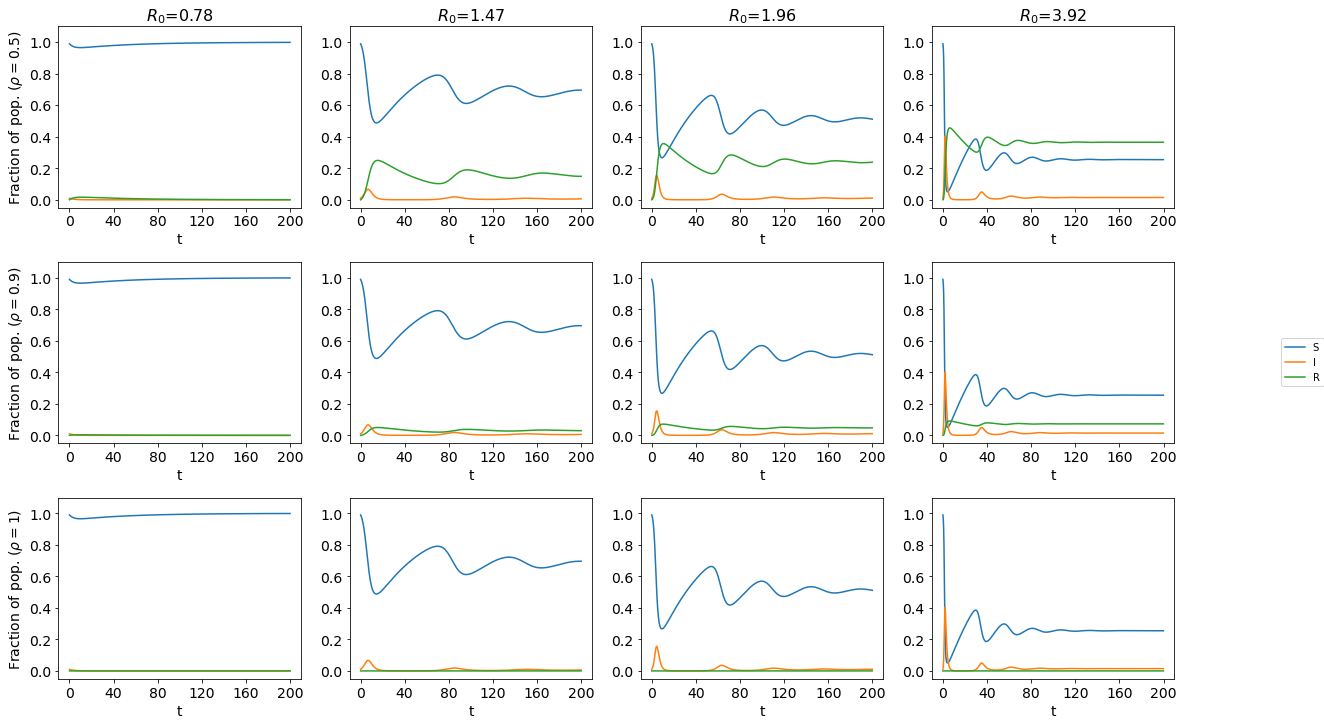

In [7]:
S0 = 0.99
I0 = 0.01
R0 = 0
SIR0 = [S0, I0, R0]
beta = [0.8, 1.5, 2, 4]
gamma = 1
t = np.arange(0, 200, 0.1)
mu = 0.02 #Natural birth and death rate set to 1/50
rho = [0.5, 0.9, 1]

#Plot integrated ODE's for various beta
fig, im = plt.subplots(len(rho), len(beta), sharey=False,figsize=(20,12))
for i in range(len(beta)):
    for j in range(len(rho)):
        SIR = ODEint(t, SIR0, beta[i], gamma, mu, rho[j])
        im[j,i].plot(t, SIR)
        im[j,i].set_xlabel('t',fontsize=14)
        if j == 0:
            im[j,i].set_title('$R_0$='+str(round(beta[i]/(gamma+mu),2)),fontsize=16)
        im[j,i].set_yticklabels(np.round(np.arange(-0.2,1.2,0.2),1),fontsize=14)
        im[j,i].set_ylim((-0.05,1.1))
        im[j,i].set_xticks(np.round(np.arange(0,220,40),0))
        im[j,i].set_xticklabels(np.round(np.arange(0,220,40),0),fontsize=14)
plt.subplots_adjust(hspace=0.3)
fig.legend(labels=['S','I','R'], loc="right",borderaxespad=0.1)
im[0,0].set_ylabel(r'Fraction of pop. ($\rho=0.5$)', fontsize=14)
im[1,0].set_ylabel(r'Fraction of pop. ($\rho=0.9$)', fontsize=14)
im[2,0].set_ylabel(r'Fraction of pop. ($\rho=1$)', fontsize=14)
fig.savefig('SIRdynamicsdemo2.pdf',dpi=100)

#### Create phase-space diagrams by solving system for varying $S_0$
Now focusing on the same variables as the plots above, with $\gamma = 1$ and varying $\rho$.

The oscillations caused by the birth and mortality rates are visible through the circling way that the phase-space diagrams converge to the stable point.

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt

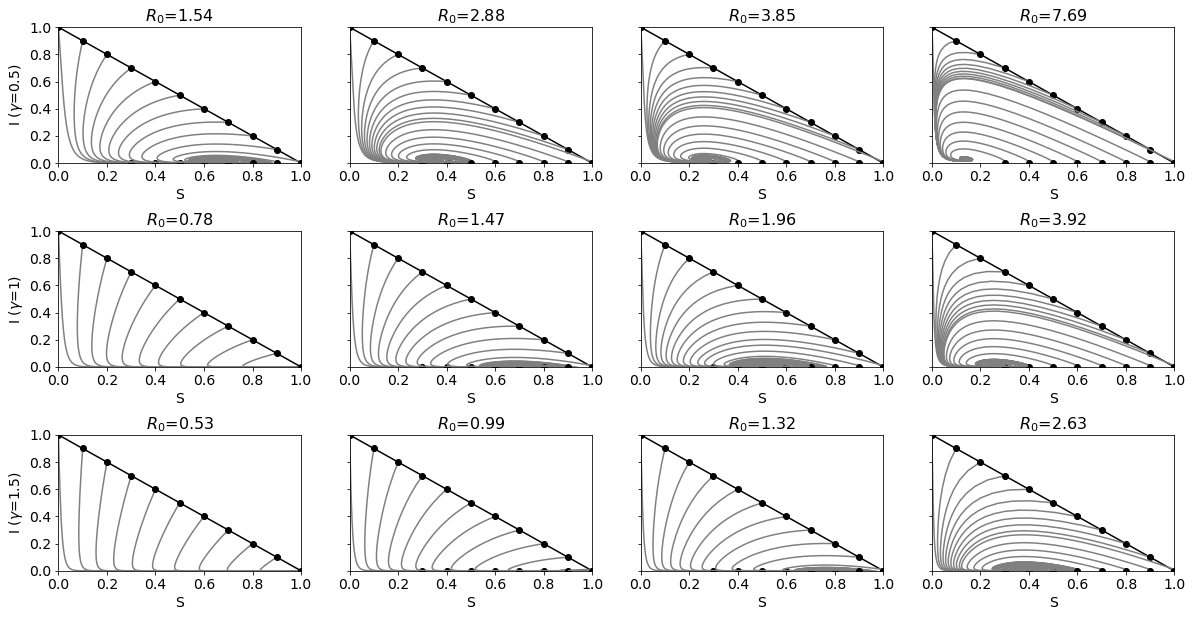

In [15]:
beta = [0.8, 1.5, 2, 4]
gamma = [0.5, 1, 1.5]
t = np.arange(0, 200, 0.1)
mu = 0.02 #Natural birth and death rate set to 1/50
rho = 0.5

S0 = np.arange(0,1.1,0.1)
fig, im = plt.subplots(len(gamma), len(beta), sharey=True, figsize=(20,10))
for i in range(len(beta)):
    for j in range(len(gamma)):
        im[j,i].set_xlabel('S', fontsize=14)
        im[j,i].set_xlim([0,1])
        im[j,i].set_ylim([0,1])
        im[j,i].set_xticklabels(np.round(np.arange(0,1.2,0.2),1),fontsize=14)
        im[j,i].set_yticklabels(np.round(np.arange(0,1.2,0.2),1),fontsize=14)
        im[j,i].plot(S0, 1 - S0, "black")
        im[j,i].set_title('$R_0$='+str(round(beta[i]/(gamma[j]+mu),2)),fontsize=16)

        for sus in S0:
            SIR = ODEint(t, [sus, (1 - sus) , 0], beta[i], gamma[j], mu, rho)
            im[j,i].plot(SIR[:,0],SIR[:,1], "grey")
            im[j,i].plot(sus, 1 - sus, 'ko')
            if beta[i]/gamma[j] >= 1 and sus > 0.3: 
                SIR = ODEint(t, [sus, I0, (1 - sus-I0)], beta[i], gamma[j], mu, rho)
                im[j,i].plot(SIR[:,0],SIR[:,1],'grey')
                im[j,i].plot(sus, 0, "ko")

plt.subplots_adjust(hspace=0.5)
im[0,0].set_ylabel(r'I ($\gamma$=0.5)', fontsize=14)
im[1,0].set_ylabel(r'I ($\gamma$=1)', fontsize=14)
im[2,0].set_ylabel(r'I ($\gamma$=1.5)', fontsize=14)
    
fig.savefig('SIRphaseplotdemo.pdf',dpi=100)

#### Redo some analysis with SEIR model
The SEIR model has an in-between stage of exposed individuals. Infection-induced mortality is not explicitely reviewed here, as it shows similar effects to the SIR model.

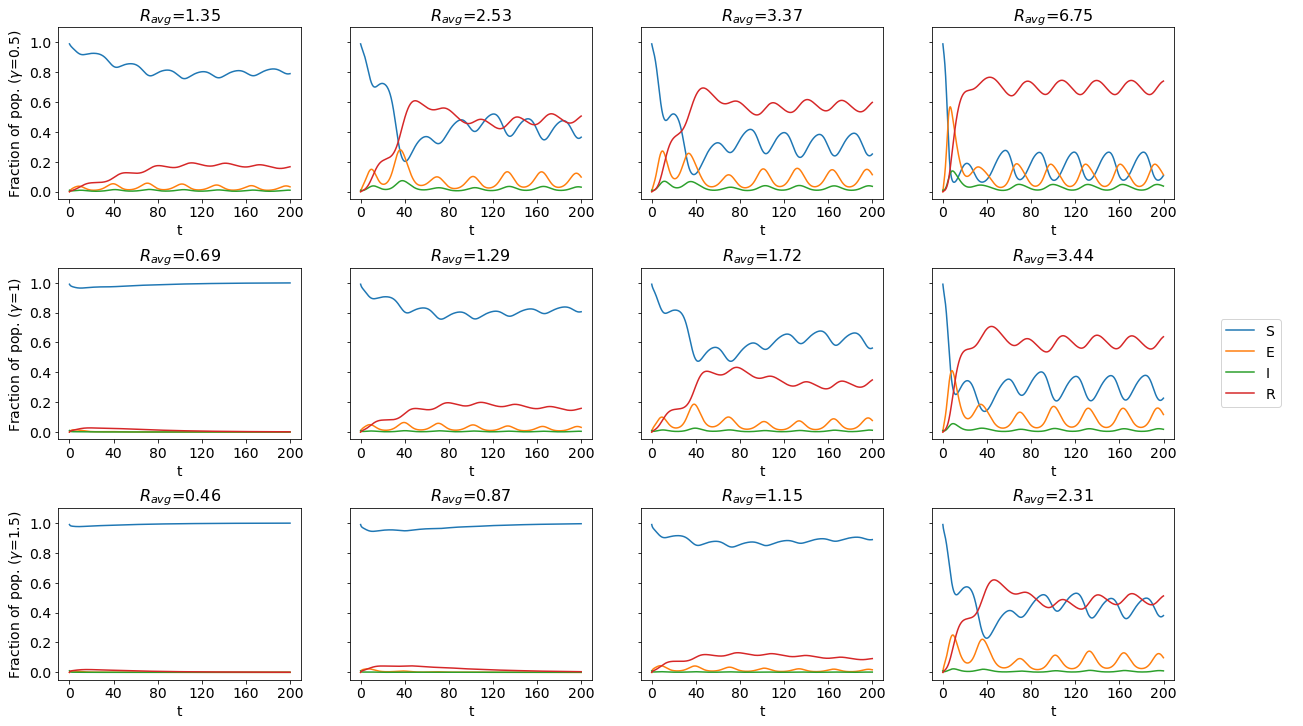

In [18]:
S0 = 0.99
E0 = 0
I0 = 0.01
R0 = 0
SEIR0 = [S0, E0, I0, R0]
beta = [0.8, 1.5, 2, 4]
gamma = [0.5, 1, 1.5]
a = 1/7
t = np.arange(0, 200, 0.1)
mu = 0.02
rho = 0

#ODE's from assignment
def ODE_SEIR(init, t, beta, gamma, mu, rho):
    S, E, I, R = init
    dsdt = mu - (1+np.cos(0.2*t)) * beta * I * S - mu * S
    dedt = (1+np.cos(0.2*t)) * beta * S * I - (mu+a) * E
    didt = a*E - gamma * I - mu * I 
    drdt = (1 - rho) * gamma * I - mu * R
    return [dsdt, dedt, didt, drdt]

def ODEint_SEIR(time, SEIR0, beta, gamma, mu, rho):
    SEIR = integrate.odeint(ODE_SEIR, SEIR0, time, args = (beta, gamma, mu, rho))
    return SEIR

#Plot integrated ODE's for various beta
fig, im = plt.subplots(len(gamma), len(beta), sharey=True,figsize=(20,12))
for i in range(len(beta)):
    for j in range(len(gamma)):
        SEIR = ODEint_SEIR(t, SEIR0, beta[i], gamma[j], mu, rho)
        im[j,i].plot(t, SEIR)
        im[j,i].set_xlabel('t',fontsize=14)
        im[j,i].set_title('$R_{avg}$='+str(round(a*beta[i]/((mu+gamma[j])*(mu+a)),2)),fontsize=16)
        im[j,i].set_yticklabels(np.round(np.arange(-0.2,1.2,0.2),1),fontsize=14)
        im[j,i].set_ylim((-0.05,1.1))
        im[j,i].set_xticks(np.round(np.arange(0,220,40),0))
        im[j,i].set_xticklabels(np.round(np.arange(0,220,40),0),fontsize=14)
        
plt.subplots_adjust(hspace=0.4)
fig.legend(labels=['S','E','I','R'], loc="right",borderaxespad=1.6,fontsize=14)
im[0,0].set_ylabel('Fraction of pop. ($\gamma$=0.5)', fontsize=14)
im[1,0].set_ylabel('Fraction of pop. ($\gamma$=1)', fontsize=14)
im[2,0].set_ylabel('Fraction of pop. ($\gamma$=1.5)', fontsize=14)
fig.savefig('SEIRdynamics.pdf',dpi=100)

#### Fourier analysis for SEIR model
Again, investigating a smaller range of $\beta$ and only focusing on $\gamma = 1$.

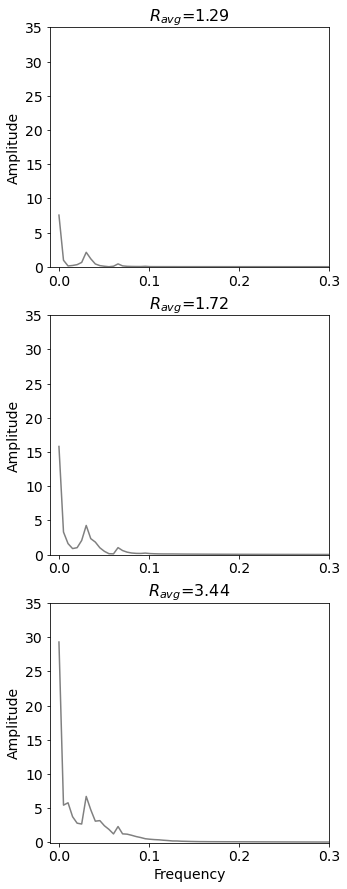

In [24]:
S0 = 0.99
E0 = 0
I0 = 0.01
R0 = 0
SIR0 = [S0, E0, I0, R0]
beta = [1.5, 2, 4]
gamma = [1]
t = np.arange(0, 200, 0.1)
mu = 0.02 #Natural birth and death rate set to 1/50
rho = 0

fig, im = plt.subplots(len(beta), len(gamma), sharex=False,figsize=(5,15))
for i in range(len(beta)):
    for j in range(len(gamma)):
        SEIR = ODEint_SEIR(t, SEIR0, beta[i], gamma[j], mu, rho)
        FT = fft(SEIR[:,2])
        FTfreq = fftfreq(len(SEIR[:,2]))
        im[i].plot(np.linspace(0,0.5,100),np.abs(FT[0:100]),'grey')
        im[i].set_title('$R_{avg}$='+str(round(a*beta[i]/((mu+gamma[j])*(mu+a)),2)),fontsize=16)
        im[i].set_ylabel('Amplitude', fontsize=14)
        im[i].set_yticklabels(np.round(np.arange(-5,40,5),1),fontsize=14)
        im[i].set_ylim((-0.05,35))
        im[i].set_xticks(np.arange(-0.1,0.6,0.1))
        im[i].set_xticklabels(np.round(np.arange(-0.1,0.4,0.1),1),fontsize=14)
        im[i].set_xlim((-0.01,0.3))
        
plt.subplots_adjust(hspace=0.2)
im[2].set_xlabel('Frequency',fontsize=14)
fig.savefig('SEIRfourier.pdf',dpi=100)

#### State-phase plots for SEIR model

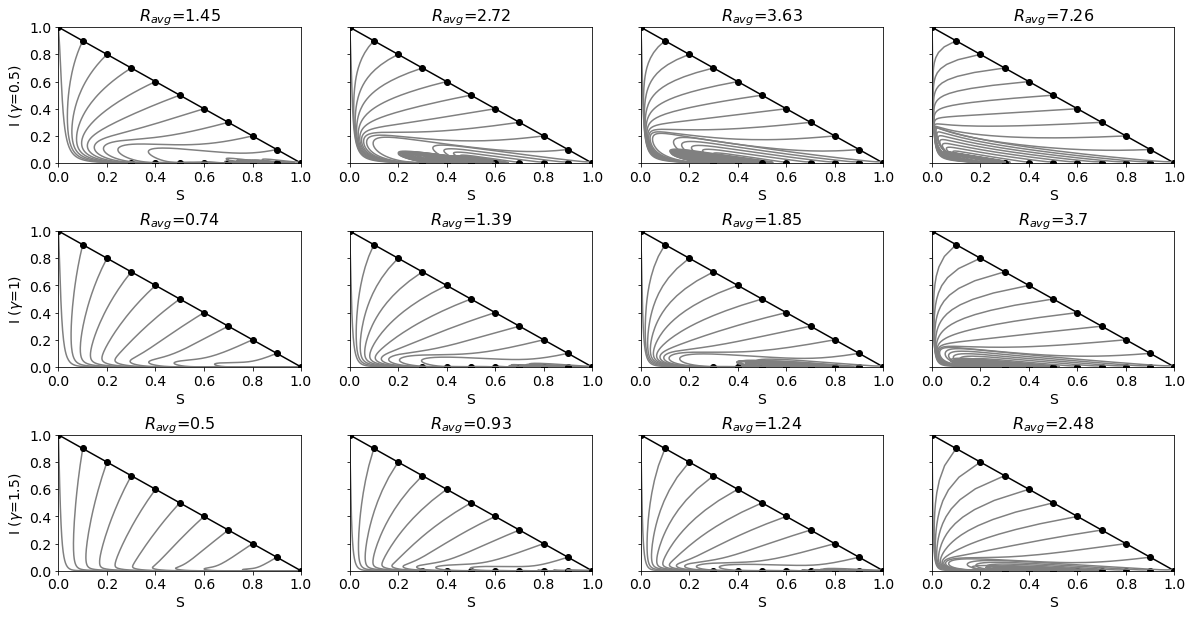

In [11]:
beta = [0.8, 1.5, 2, 4]
gamma = [0.5, 1, 1.5]

S0 = np.arange(0,1.1,0.1)
fig, im = plt.subplots(len(gamma), len(beta), sharey=True, figsize=(20,10))
for i in range(len(beta)):
    for j in range(len(gamma)):
        im[j,i].set_xlabel('S', fontsize=14)
        im[j,i].set_xlim([0,1])
        im[j,i].set_ylim([0,1])
        im[j,i].set_xticklabels(np.round(np.arange(0,1.2,0.2),1),fontsize=14)
        im[j,i].set_yticklabels(np.round(np.arange(0,1.2,0.2),1),fontsize=14)
        im[j,i].plot(S0, 1 - S0, "black")
        im[j,i].set_title('$R_{avg}$='+str(round(a*beta[i]/((mu+gamma[j])*(mu+a)),2)),fontsize=16)

        for sus in S0:
            SEIR = ODEint_SEIR(t, [sus, 0, (1 - sus) , 0], beta[i], gamma[j], mu, rho)
            im[j,i].plot(SEIR[:,0],SEIR[:,2], "grey")
            im[j,i].plot(sus, 1 - sus, 'ko')
            if beta[i]/gamma[j] >= 1 and sus > 0.3: 
                SEIR = ODEint_SEIR(t, [sus, 0, I0, (1 - sus-I0)], beta[i], gamma[j], mu, rho)
                im[j,i].plot(SEIR[:,0],SEIR[:,2],'grey')
                im[j,i].plot(sus, 0, "ko")

plt.subplots_adjust(hspace=0.5)
im[0,0].set_ylabel('I ($\gamma$=0.5)', fontsize=14)
im[1,0].set_ylabel('I ($\gamma$=1)', fontsize=14)
im[2,0].set_ylabel('I ($\gamma$=1.5)', fontsize=14)
    
fig.savefig('SEIRphaseplot.pdf',dpi=100)